In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing, merging, exploring and cleaning for the hazardous waste datasets.

In [103]:
#Importing the datasets below: 

haz_waste = pd.read_excel("farlig_avfall.xlsx") #This is the main dataset on waste per facility
facility_1 = pd.read_excel("anlegg_adresse.xlsx") #This is a dataset with address of each facility, exl closed ones
facility_2 = pd.read_excel("anlegg_adresse_v2.xlsx") #This is a dateset later aquired with closed facilities, to be able to complete the following merge.

In [104]:
#Vertical concatenate facility dateframes into one complete.
facility_complete = pd.concat([facility_2, facility_1]).drop_duplicates().reset_index(drop=True) 

#Fill NaNs for columns "Status and "Status ansvarlig enhet"with active for active facilties, as this column name was only included in the closed facilites dataset.
facility_complete[["Status", "Status ansvarlig enhet"]]=facility_complete[["Status", "Status ansvarlig enhet"]].fillna("Aktiv") 

In [105]:
#merging the waste dataset with the facility dataset
waste_merged = pd.merge(haz_waste, facility_complete, how="left", left_on="AnleggNummer", right_on="Anleggsnr.")

In [106]:
#Checking number of unique values in each column.
waste_merged.nunique()

År                                                                         32
AnleggNummer                                                             1292
AnleggNavn                                                               1289
Anleggsaktivitet_x                                                         30
Org.nr                                                                   1162
Farlig avfallskode (EAL)                                                  905
Avfallskode (NS 9431)                                                      69
Enhet                                                                       3
På mellomlager                                                           1344
Til gjenvinning i Norge                                                  7501
Til sluttbehandling i Norge                                              5821
Til gjenvinning i utlandet                                                583
Til sluttbehandling i utlandet                                  

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='År', ylabel='Total mengde'>

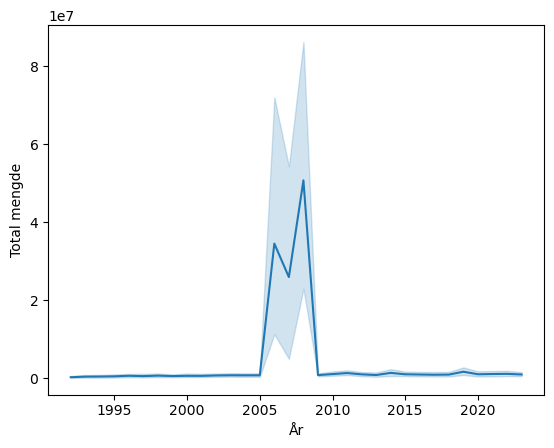

In [107]:
#Making a lineplot to see overall development of hazardous waste per year.
sns.lineplot(data=waste_merged, x="År", y="Total mengde", estimator=np.sum)

<Axes: xlabel='År', ylabel='Total mengde'>

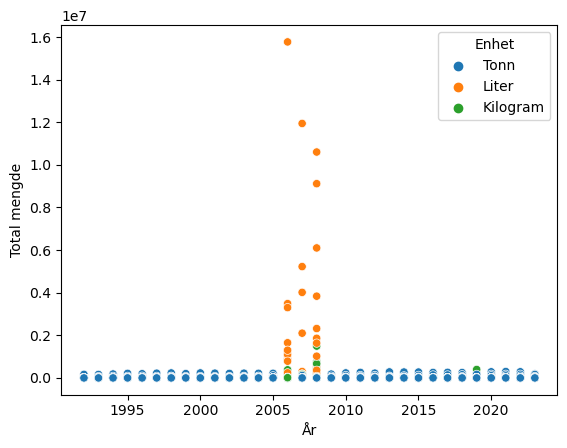

In [108]:
#Checking waste unit to check spike in 2006-08.
sns.scatterplot(data=waste_merged, x="År", y="Total mengde", hue="Enhet")

In [109]:
#Defining a converter to convert kilogram and liter to ton.
def to_ton_converter(row, amount_col, unit_col, kg_to_ton=0.001, liter_to_ton=0.0008):
    amount = row[amount_col]
    unit = row [unit_col]

    if unit == 'Kilogram':
        return amount * kg_to_ton
    elif unit == 'Liter':
        return amount * liter_to_ton
    elif unit == 'Tonn':
        return amount
    else:
        return None
    
#Defining columns to convert and the unit_col.
columns_to_convert = [
    ("På mellomlager", "Mellomlager i tonn"),
    ("Til gjenvinning i Norge", "Gjenvinning Norge i tonn"),
    ("Til sluttbehandling i Norge", "Sluttbehandling Norge i tonn"),
    ("Til gjenvinning i utlandet", "Gjenvinning utland i tonn"),
    ("Til sluttbehandling i utlandet", "Sluttbehandling utland i tonn"),
    ("Egenbehandlet avfall, forbrenning / pyrolyse med energi-gjenvinning", "Egenbeh forbrenning m energi-gjenvinning i tonn"),
    ("Egenbehandlet avfall, forbrenning / pyrolyse uten energi-gjenvinning", "Egenbeh forbrenning u energigjenvinning i tonn"),
    ("Egenbehandlet avfall, eget godkjent deponi", "Egenbeh eget godkjent deponi i tonn"),
    ("Egenbehandlet avfall, annen behandling", "Egenbeh annen behandling i tonn"),
    ("Total mengde", "Tot mengde i tonn")
]

unit_col = "Enhet"

#Using a for loop to loop through each row or every relevant columns and applying the to_ton_coverter to it. See columns_to_convert above.
for amount_col, result_col in columns_to_convert:
    waste_merged[result_col] = waste_merged.apply(
        lambda row: to_ton_converter(row, amount_col=amount_col, unit_col=unit_col), axis=1
    )

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='År', ylabel='Tot mengde i tonn'>

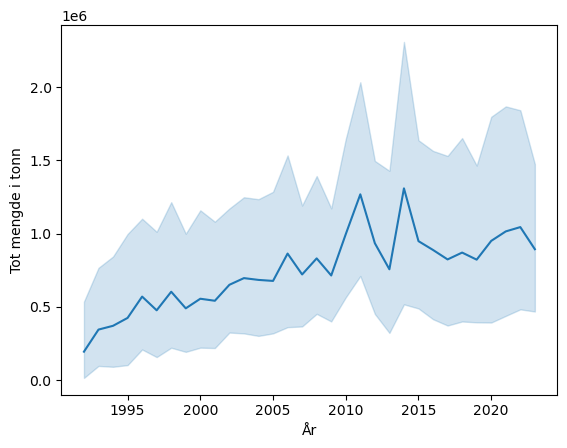

In [110]:
#A lineplot showing total amount of waste per year after converting kilograms and liters to ton.
sns.lineplot(data=waste_merged, x="År", y="Tot mengde i tonn", estimator=np.sum)

In [111]:
#Making a leaner dataframe and grouping it to fit the prescription drugs data.
waste_groupby_kommune_and_year = waste_merged[["År", "Kommune", "Tot mengde i tonn"]].groupby(["Kommune", "År"]).sum()
waste_groupby_kommune_and_year.reset_index(inplace=True) #Resetting the index to keep the columns.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Tot mengde i tonn', ylabel='Count'>

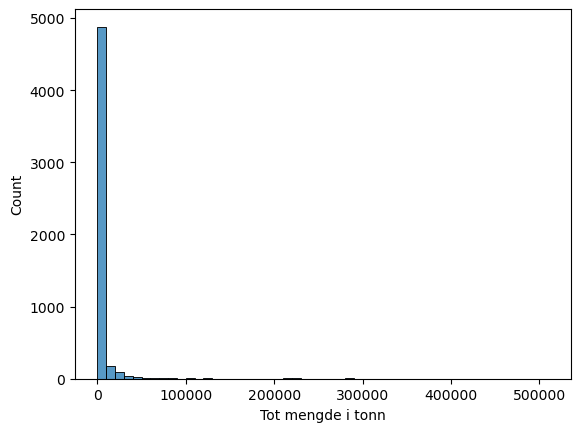

In [112]:
#Checking the distribution of waste per "Kommune" per "År"
sns.histplot(data=waste_groupby_kommune_and_year, x="Tot mengde i tonn", binwidth=10000)

Importing, cleaning, unstacking and merging prescription drugs datasets

In [113]:
#Importing Excel files on prescription drugs to dataframes.
diabetes_type_II = pd.read_excel("diabetes_type_II.xls", header=7)
prescription_drugs = pd.read_excel("Legemiddelbrukere_ny.xls", header=8)

#Because of merged cells in the original Excel file, using ffill to fill in NaNs below with value above.
diabetes_type_II.ffill(inplace=True)
prescription_drugs.ffill(inplace=True)

#Renaming some columns to make more sense of them and for easier merge later.
diabetes_type_II.rename(columns={"År": "År_snitt", "Geografi": "Kommune"}, inplace=True)
prescription_drugs.rename(columns={"År": "År_snitt", "Geografi": "Kommune"}, inplace=True)

#Naming nameless columns.
diabetes_type_II.columns.values[2] = "Type_2-diabetes"
prescription_drugs.columns.values[3] = "Per_1000"

#Unstacking the one prescription drug set, so that each prescription drug has its own column, thus making it easier to merge with the Type 2 diabetes dataset. 
prescription_drugs_unstacked = prescription_drugs.set_index(["År_snitt", "Kommune", "Legemiddelgruppe"])["Per_1000"].unstack()
prescription_drugs_unstacked.reset_index(inplace=True) #Reset index to keep individual columns.

#Merging the main prescription drug dataset (allergy, asthma, ADHD, diabetes) with the Type 2 diabetes dataset.
prescription_complete = pd.merge(prescription_drugs_unstacked, diabetes_type_II, how="inner", on=["Kommune", "År_snitt"])

#Seperating out the last year of the three year rolling mean into a new columns that then can be merged with the waste data.
prescription_complete["År"] = prescription_complete["År_snitt"].str.split("-").str[1]
prescription_complete["År"] = prescription_complete["År"].astype(int)

#Rename some prescription drug columns for easier edibilty and handling. 
prescription_complete.rename(columns={"Diabetesmedikamenter (A10)": "Diabetes", "Midler mot astma og KOLS (R03 unntatt R03CA)": "Astma_og_KOLS", "Allergimidler (R06A, R01AC, R01AD, R01B, S01G)": "Allergi", "ADHD-midler (C02AC02, N06BA ekskl. N06BA07)": "ADHD"}, inplace=True)

#Selecting the prescription drugs selected for this project into a leaner dataframe. 
prescription_to_correlate = prescription_complete[["År", "Kommune", "Diabetes", "Type_2-diabetes", "Astma_og_KOLS", "Allergi", "ADHD"]]

Merging waste and prescription dataframes into one, and segmenting into low waste and high waste municipalities.

In [114]:
#Merging waste df and prescription df to make a new dataset ready to do a correlation analysis:
waste_prescription = pd.merge(waste_groupby_kommune_and_year, prescription_to_correlate, how="inner", on=["Kommune", "År"])

#Converting object type numeric values to float for prescription drug columns.
for col in waste_prescription.columns[3:]:
    waste_prescription[col] = pd.to_numeric(waste_prescription[col], errors="coerce")

#Removing rows where there is no data on prescription drugs, either because of privacy or other reasons.
waste_prescription = waste_prescription[~waste_prescription.isin(['..']).any(axis=1)]
waste_prescription = waste_prescription[~waste_prescription.isin([':']).any(axis=1)]
waste_prescription = waste_prescription[~waste_prescription.isnull().any(axis=1)]

#Grouping by municipality to calculate the mean, then make a list of municipalities with waste > 1000 per year.
waste_mean_kom = waste_prescription.groupby(by="Kommune")["Tot mengde i tonn"].mean()
waste_mean_kom = pd.DataFrame(waste_mean_kom.reset_index())
above_1000_ton = waste_mean_kom.query("`Tot mengde i tonn`> 1000")
list_kom=above_1000_ton['Kommune']
high_waste_prescription = waste_prescription.query("Kommune in @list_kom") #Using the list to create a high_waste dataframe ...
low_waste_prescription = waste_prescription.query("Kommune not in @list_kom") #... and a low_waste dataframe.

#Creating a label column for low waste municipalities and high waste municipalities.
low_waste_prescription["label"]="low"
high_waste_prescription["label"]="high"

/var/folders/33/6w2rzj_d6gq243399v2ty2q80000gn/T/ipykernel_47176/1282358848.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/33/6w2rzj_d6gq243399v2ty2q80000gn/T/ipykernel_47176/1282358848.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
#Confirming the right datatypes for the dataframe.
print(waste_prescription.dtypes)

Kommune               object
År                     int64
Tot mengde i tonn    float64
Diabetes             float64
Type_2-diabetes      float64
Astma_og_KOLS        float64
Allergi              float64
ADHD                 float64
dtype: object


In [116]:
#printing number of unique municipalites in each dataset. 
print(low_waste_prescription["Kommune"].nunique(), high_waste_prescription["Kommune"].nunique())

139 64


Calculating the correlation coeefficient (Pearson's) of each municipality.

In [117]:
#Importing personr for correlation coefficient and p-value from scipy.
from scipy.stats import pearsonr

#Defining a prescription_waste_correlator that can be applied to all prescription drug columns, and group the data by municipality. 
def prescription_waste_correlator(data, waste_col, group_col="Kommune", year_col="År"):
    prescription_cols = [col for col in data.columns[3:8]] #Defining the columns to loop through.
    results = pd.DataFrame() 

    for prescription_col in prescription_cols:
        #Grouping the data by Kommune (group_col) here.
        group_data = data[[group_col, waste_col, prescription_col]].groupby([group_col])
        
        #Initializing lists to add municipalites, correlation coefficients and p_values when looping.
        list_kom = []
        list_corr = []
        list_p_value = []

        #Calculating the correlation coefficient and p-value for each group (municipality) on waste and the different prescription columns. And appending the values to the lists defined above.
        for name, group in group_data: 
            corr_val, p_value = pearsonr(group[waste_col], group[prescription_col])
            list_kom.append(name)
            list_corr.append(corr_val)
            list_p_value.append(p_value)
        
        #Creating a dataframe to combine the lists.
        prescription_results = pd.DataFrame({
            group_col: list_kom,
            "Legemiddel": prescription_col,
            "Korrelasjon": list_corr,
            "P-value": list_p_value
        })
        
        #Concatenating for each run of the loop.
        results = pd.concat([results, prescription_results], ignore_index=True)

    return results

In [118]:
#Running the prescription_waste_correlator function on the high_waste_prescription dataframe. 
correlation_results = prescription_waste_correlator(high_waste_prescription, "Tot mengde i tonn")

#Only select results with a p-value of < 0,05.
p_value_0_05 = correlation_results.query("`P-value` < 0.05")

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Korrelasjon', ylabel='Count'>

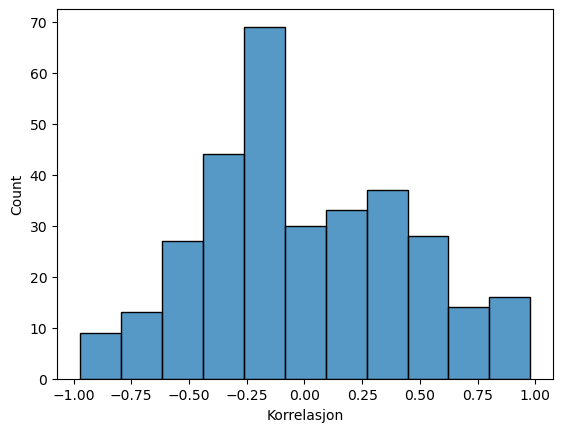

In [119]:
#Checking the distribution of the correlation results.
sns.histplot(data=correlation_results, x="Korrelasjon")

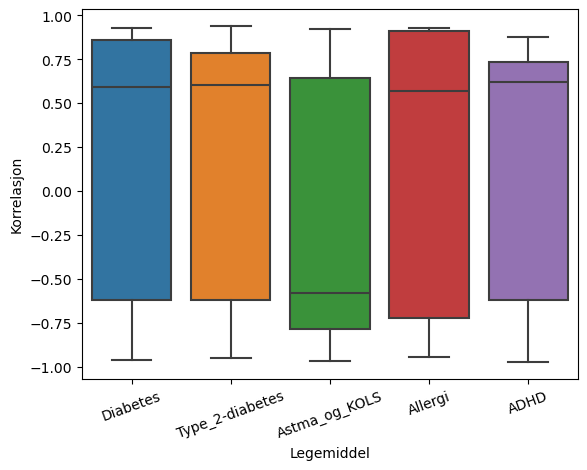

In [120]:
#Boxplot to show the distribution of different prescription drugs.
ax = sns.boxplot(data=p_value_0_05, y="Korrelasjon", x="Legemiddel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20) #Rotating the x axis a bit to increase legibility. 
plt.show()


Comparing low waste with high waste, using the labels created earlier and concatenating back into on combinded dataframe.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda

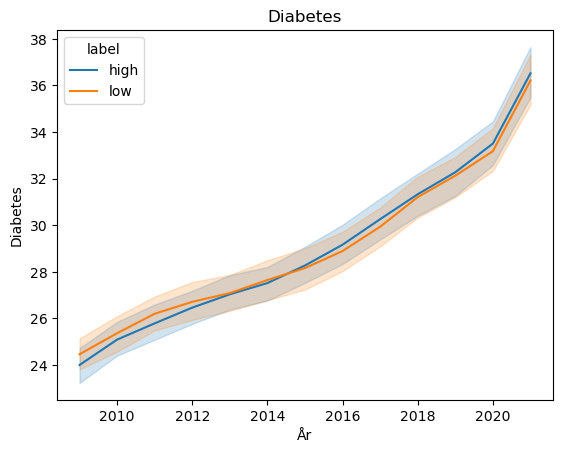

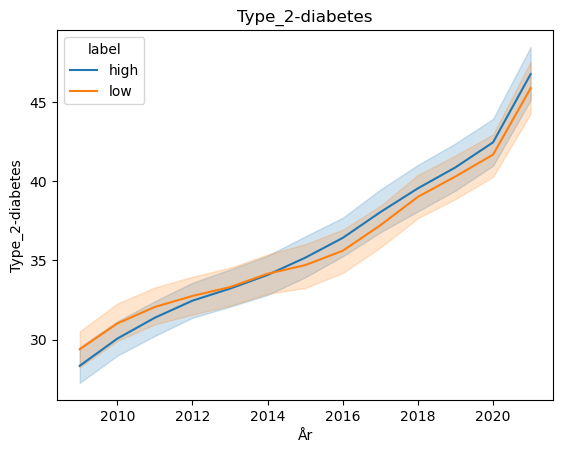

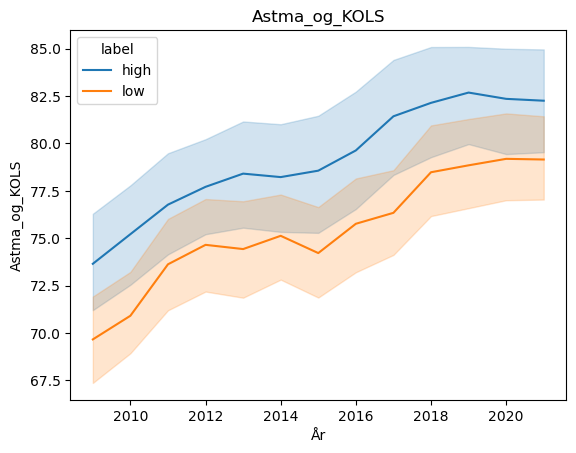

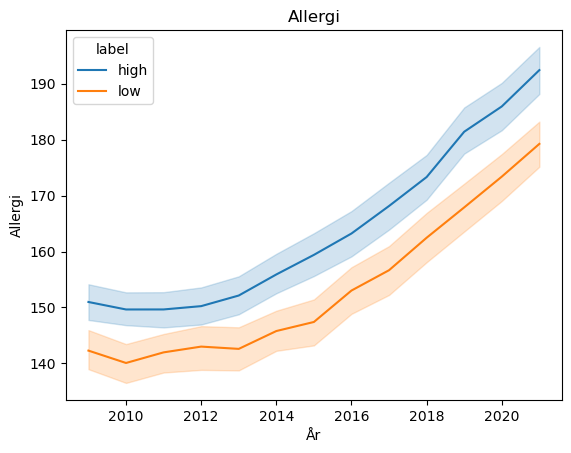

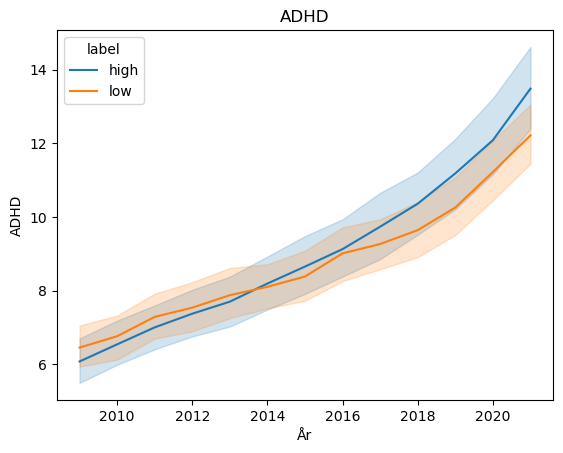

In [121]:
#Concatenating high_waste with low_waste to create a full dataset, now including low and high labels.
combined_df = pd.concat([high_waste_prescription, low_waste_prescription])

#Loopig through the prescription drug columns creating a lineplot for each, using the high/low label with the hue paramenter.
for legemiddel in combined_df.columns[3:8]:
    
    plt.figure()
    
    sns.lineplot(data=combined_df, x="År", y=legemiddel, hue="label", estimator=np.mean)
    plt.title(legemiddel)
plt.show()

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Allergi', ylabel='Count'>

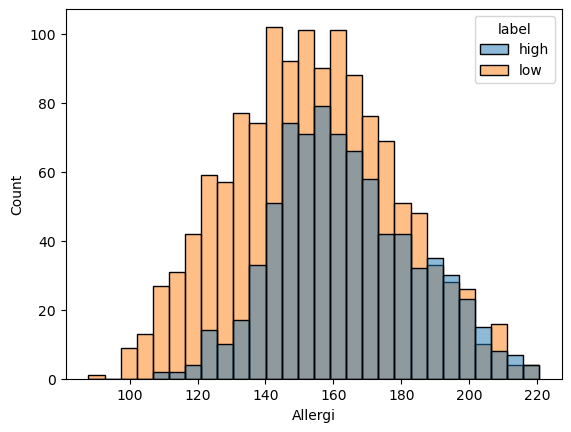

In [122]:
#Creating a histograph to see the allergy distribution for high vs low waste municipalities.
sns.histplot(data=combined_df, x="Allergi", hue="label")

Further investigation into allergy, aiming to find a relationship between waste and prescription rates.

<Axes: xlabel='Tot mengde i tonn', ylabel='Allergi'>

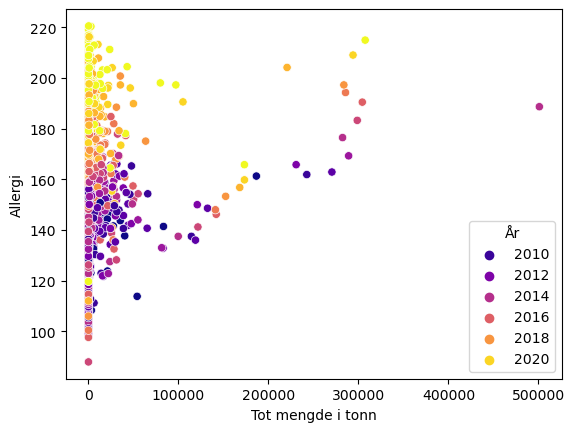

In [123]:
sns.scatterplot(data=waste_prescription, y="Allergi", x="Tot mengde i tonn", hue="År", palette="plasma")

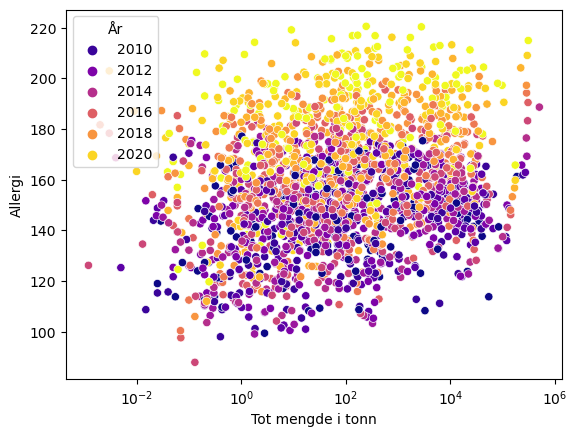

In [124]:
sns.scatterplot(data=waste_prescription, y="Allergi", x="Tot mengde i tonn", hue="År", palette="plasma")
plt.xscale("log") #Adding a logarithmic scale to the x axis (waste)

Regression analysis on waste and allergy prescription

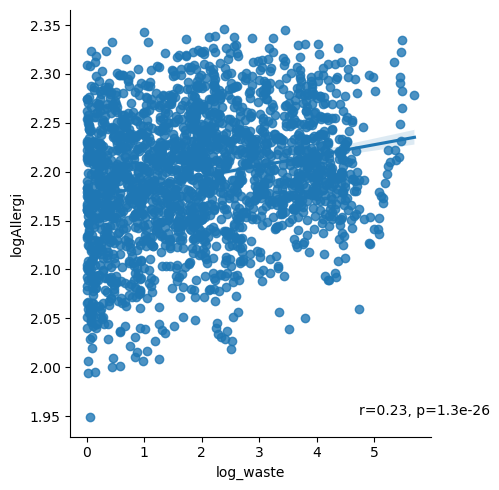

In [125]:
from scipy.stats import spearmanr

prescription = "Allergi"
correlator = pearsonr #to easily switch between pearsonr and spearmanr

#Creating logarithmic colums of waste and prescription.
waste_prescription["log_waste"] = np.log10(waste_prescription["Tot mengde i tonn"]+1)
waste_prescription["log"+prescription] = np.log10(waste_prescription[prescription]+1)


g = sns.lmplot(data=waste_prescription, y="log"+prescription, x="log_waste")

#Function to calculate the correlation of the whole dataset, using logarithmic scale, and to annotate the corr_value and p_value to the plot.
def annotate(data, **kws):
    r, p = correlator(data["log"+prescription], data['log_waste'])
    ax = plt.gca()
    ax.text(.8, .05, "r={:.2f}, p={:.2g}".format(r, p),
            transform=ax.transAxes)
g.map_dataframe(annotate)

plt.show()

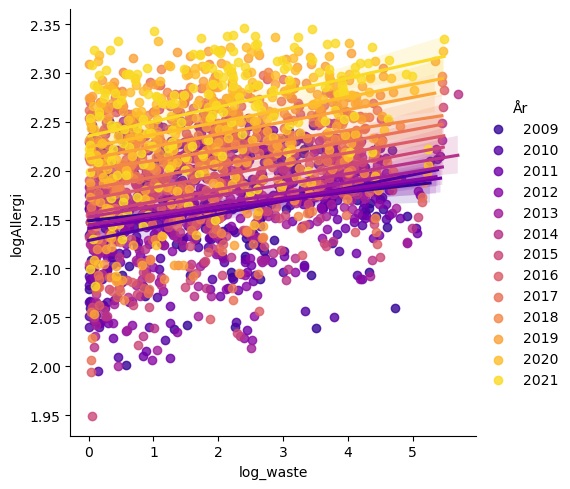

In [126]:
#Adding hue="År" to the lineplot to visualize regression per year.
sns.lmplot(data=waste_prescription, y="log"+prescription, x="log_waste", hue="År", palette="plasma")

Using a for loop to calculate correlation and p-value for each year and storing the results in a results dataframe.


In [127]:
#Get unique years
years = waste_prescription["År"].unique()

#Dictionary to store results
results = {"year": [], "corr": [], "p_value": []}

#Loop through each year
for year in years:
    #Filter data for the current year
    waste_prescription_years = waste_prescription[waste_prescription["År"] == year]
    
    #Calculate the correlation (Pearson's or Spearman's depending on input above) and p-value
    corr, p_value = correlator(waste_prescription_years["Allergi"], waste_prescription_years["log_waste"])
    
    #Store the results
    results["year"].append(year)
    results["corr"].append(corr)
    results["p_value"].append(p_value)

#Convert results to a dataframe
results_df = pd.DataFrame(results)

#Sorting the results by years.
results_df.sort_values(by="year", inplace=True)

print(results_df)


    year      corr       p_value
0   2009  0.184442  1.771254e-02
1   2010  0.332108  7.571367e-06
2   2011  0.256080  8.368749e-04
3   2012  0.242555  1.810795e-03
4   2013  0.260373  9.530464e-04
5   2014  0.270970  4.138136e-04
6   2015  0.291495  2.332834e-04
7   2016  0.274755  6.134163e-04
12  2017  0.281541  3.542118e-04
8   2018  0.250251  1.319165e-03
9   2019  0.297622  1.034680e-04
10  2020  0.329243  1.671721e-05
11  2021  0.380286  2.889836e-07


/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/andreasfosse/anaconda3/envs/oslomet/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='year', ylabel='corr'>

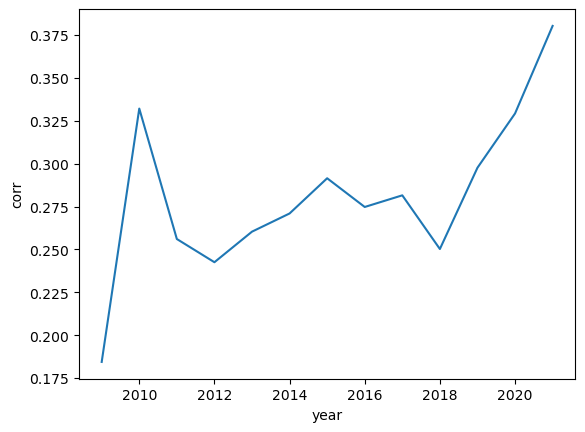

In [128]:
sns.lineplot(data=results_df, x="year", y="corr") #a lineplot of correlation over time.

Creating a 3D scatter plot with the help of Plotly and ChatGPT.

In [129]:

import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

plot_data = waste_prescription

#Define variable names
x_column = "log_waste"
y_column = "År"
z_column = "logAllergi"

#Prepare the features and target arrays
X = plot_data[[x_column, y_column]]
y = plot_data[z_column]

#Fit the regression model
model = LinearRegression()
model.fit(X, y)

# Create an array for predictions
X_pred = pd.DataFrame({
    x_column: np.linspace(X[x_column].min(), X[x_column].max(), 100),
    y_column: np.linspace(X[y_column].min(), X[y_column].max(), 100)
})
y_pred = model.predict(X_pred)

# Create the figure
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter3d(x=plot_data[x_column], y=plot_data[y_column], z=plot_data[z_column],
                           mode='markers', marker=dict(size=2, color='blue',)),)

# Add line plot
fig.add_trace(go.Scatter3d(x=X_pred[x_column], y=X_pred[y_column], z=y_pred,
                           mode='lines', line=dict(color='red', width=2)))

# Update plot appearance
fig.update_layout(title='3D Regression Line Plot',
                  scene=dict(
                      xaxis_title=x_column,
                      yaxis_title=y_column,
                      zaxis_title=z_column))

# Show plot
fig.show()
